In [1]:
import os
os.environ["JAX_PLATFORM_NAME"] = "cpu"

import adaptive_latents as al
from adaptive_latents import NumpyTimedDataSource, Bubblewrap, AnimationManager, default_rwd_parameters, SymmetricNoisyRegressor, BWRun
import adaptive_latents.input_sources.functional as fin
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from proSVD import proSVD
rng = np.random.default_rng()
# al.input_sources.datasets.construct_unpublished24()

In [2]:
import h5py
import pandas as pd

In [3]:
mat = loadmat(al.CONFIG['data_path'] / 'Chestek' / 'jgould_first_extraction.mat', squeeze_me=True, simplify_cells=True)
pre_smooth_beh = mat["feats"][1]
pre_smooth_A = mat["feats"][0]
pre_smooth_t = mat["feats"][2] / 1000

pre_smooth_beh = pre_smooth_beh.reshape((pre_smooth_beh.shape[0], 3, 5))

nonzero_columns = pre_smooth_beh.std(axis=0) > 0
assert np.all(~(nonzero_columns[0,:] ^ nonzero_columns)) # checks that fingers always have the same values
pre_smooth_beh = pre_smooth_beh[:,:,nonzero_columns[0,:]] # the booleans select for position, velocity, and acceleration
pre_smooth_beh = pre_smooth_beh[:, [True, False, False], :].reshape(pre_smooth_beh.shape[0], -1) # the three booleans select for position, velocity, and acceleration

Text(0.5, 1.0, 'Convolution kernel')

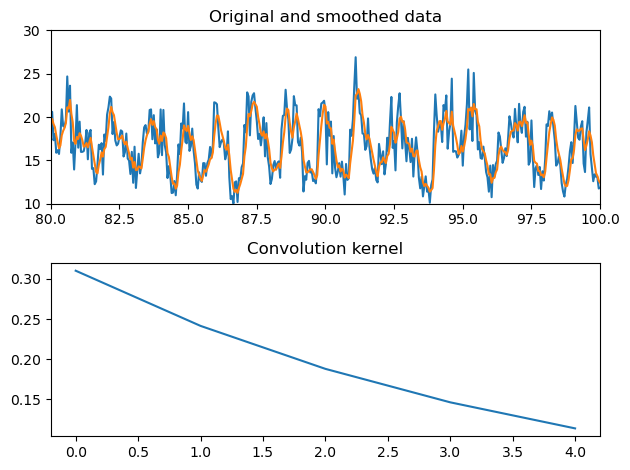

In [4]:
# pre_A, pre_beh, pre_t, _ = al.input_sources.datasets.construct_nason20_dataset()

fig,ax = plt.subplots(nrows=2, layout="tight")
ax[0].plot(pre_smooth_t, pre_smooth_A[:,0])
signal = pre_smooth_A[:,0]

kernel = np.exp(np.linspace(0,-1,5))
kernel /= kernel.sum()
ax[1].plot(kernel)

mode = 'valid'
smoothed = np.convolve(kernel, signal, mode)
smoothed_t = np.convolve(np.hstack([[1],kernel[:-1]*0]), pre_smooth_t, mode)
ax[0].plot(smoothed_t,smoothed)


ax[0].set_xlim([80, 100])
ax[0].set_ylim([10, 30])
ax[0].set_title("Original and smoothed data")
ax[1].set_title("Convolution kernel")

In [5]:
mode = 'valid'
pre_prosvd_A = np.column_stack([np.convolve(kernel, column, mode) for column in pre_smooth_A.T])
pre_prosvd_t = np.convolve(np.hstack([[1],kernel[:-1]*0]), pre_smooth_t, mode)
pre_prosvd_beh = pre_smooth_beh

# n = pre_prosvd_A.shape[0]
# slice = np.arange(n) < n//2
# pre_prosvd_A, pre_prosvd_beh, pre_prosvd_t = (np.vstack([pre_prosvd_A[slice], pre_prosvd_A[slice] @ permutation][::-1]),
#              pre_prosvd_beh, 
#              pre_prosvd_t
#             )


pre_prosvd_A = fin.center_from_first_n(pre_prosvd_A, 100)
pre_prosvd_A, pre_prosvd_beh, pre_prosvd_t = fin.clip(pre_prosvd_A, pre_prosvd_beh, pre_prosvd_t)



pre_jpca_A, Qs = fin.prosvd_data_with_Qs(pre_prosvd_A, 4, 50)
pre_jpca_A, pre_jpca_t, pre_jpca_beh = fin.clip(pre_jpca_A, pre_prosvd_t, pre_prosvd_beh)

In [6]:
pre_splice_A, pre_splice_beh, pre_splice_t = pre_jpca_A, pre_jpca_beh, pre_jpca_t

In [7]:



A, beh, t = pre_jpca_A, pre_jpca_beh, pre_jpca_t

##### to skip

Text(0.5, 0, 'number of components')

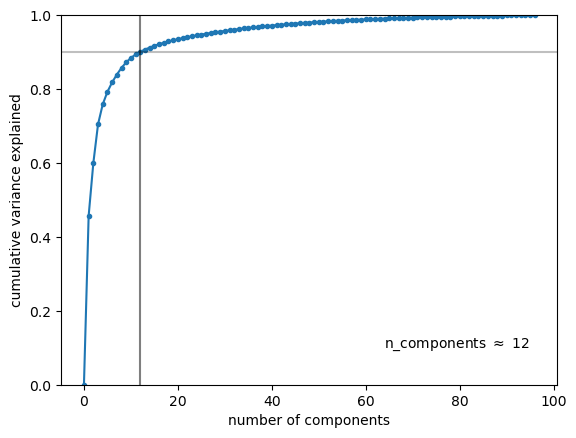

In [8]:
pca = PCA()
pca.fit(pre_prosvd_A)

fig, ax = plt.subplots()
var_explained = np.cumsum([0] + list(pca.explained_variance_ratio_))
ax.plot(var_explained, '.-')
ax.set_ylim([0,1])
cutoff = np.nonzero(var_explained > .9)[0][0]
ax.axvline(cutoff, color='k', alpha=.5)
ax.axhline(.9, color='k', alpha=.25)
ax.text(.65,.1, f'n_components $\\approx$ {cutoff}', transform=ax.transAxes)
ax.set_ylabel("cumulative variance explained")
ax.set_xlabel("number of components")

In [9]:
# fig, ax = plt.subplots(nrows=2, layout="tight")
# dQ = np.linalg.norm(np.diff(Qs, axis=0), axis=1)
# dt = np.diff(pre_prosvd_t)
# ax[0].plot(t[:-1], dQ/dt[:,None]);
# ax[0].set_ylabel("$\\frac{ \\Vert dQ_i \\Vert}{dt}$");
# ax[0].set_title("Change in proSVD vectors over time");
# ax[0].set_xlabel("time (s)");

# ax[1].plot(t[:-1], np.log(dQ/dt[:,None]));
# ax[1].set_ylabel("$\\ln \\frac{ \\Vert dQ_i \\Vert}{dt}$");
# ax[1].set_title("(log scale)");
# ax[1].set_xlabel("time (s)");

In [10]:
# %matplotlib inline
# fig, axs = plt.subplots(nrows=3, ncols=3, sharey='row')

# slice_half_width = 20
# time_slices = [slice(0,slice_half_width*2), 
#                slice(len(t)//2-slice_half_width, len(t)//2+slice_half_width) , 
#                slice(-slice_half_width*2, -1)]
# for i in range(3):
#     s = time_slices[i]
#     axs[0,i].plot(t[s],beh[s])
#     axs[0,i].set_xlim([min(t[s]), max(t[s])])
#     axs[1,i].imshow(A[s,:].T, aspect='auto', interpolation='none')
#     axs[1,i].set_xticks([])
#     axs[2,i].plot(t[s],A[s,:], color='k', alpha=.25)
#     axs[2,i].set_xlim([min(t[s]), max(t[s])])

# axs[0,0].set_title(f"first {slice_half_width*2} points")
# axs[0,1].set_title(f"middle {slice_half_width*2} points")
# axs[0,2].set_title(f"last {slice_half_width*2} points")

# axs[0,0].set_ylabel("Behavior")
# axs[1,0].set_ylabel("Neural Latents")
# axs[2,0].set_ylabel("Neural Latents")
# axs[2,1].set_xlabel("time (s)");

##### bw

In [11]:
in_ds = NumpyTimedDataSource(A, t, time_offsets=(0,1))
out_ds = NumpyTimedDataSource(beh, t, time_offsets=(0,1))

# define the adaptive_latents object
bw = Bubblewrap(dim=in_ds.output_shape,  **dict(default_rwd_parameters, M=300, num=500, num_grad_q=1))

# define the (optional) method to regress the HMM state from `bw.alpha`
# reg = SymmetricNoisyRegressor(input_d=bw.N, output_d=1)
reg = al.regressions.HistoricalSNR(input_d=bw.N, output_d=out_ds.output_shape, init_min_ratio=.5)

class CustomAnimation(AnimationManager):
    n_rows = 1
    n_cols = 3
    figsize = (15,10)
    extension = "mp4"
    fps=10

    def custom_draw_frame(self, step, bw: Bubblewrap, br: BWRun):
        historical_observations, _ = br.obs_ds.get_history()

        al.plotting_functions.show_active_bubbles_and_connections_2d(self.ax[0,1], historical_observations, bw, n_sds=3, history_length=10)
        self.ax[0,1].set_title(f"Step {step}")
        al.plotting_functions.show_alpha(self.ax[0,0], br)
        al.plotting_functions.show_behavior(self.ax[0,2], br)
        
    def frame_draw_condition(self, step_number, bw):
        condition = True
        condition = condition and (step_number % 1 == 0)
        condition = condition and (350 < step_number < 1600)
        return condition
        
am = CustomAnimation() if False else None

br = BWRun(bw=bw, obs_ds=in_ds, beh_ds=out_ds, behavior_regressor=reg, animation_manager=am, show_tqdm=True, save_A=True)

br.run(limit=557,save=True)

558it [00:08, 62.87it/s]                                                        


In [12]:
np.argmax(br.alpha_history[0][-1])

40

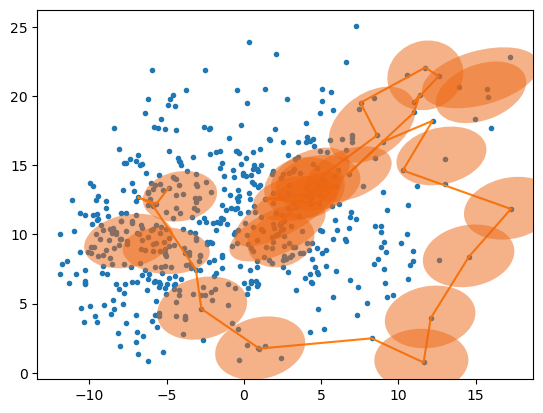

In [13]:
historical_observations, _ = br.obs_ds.get_history()
n_steps = 30

fig, ax = plt.subplots()
ax.plot(historical_observations[:,0], historical_observations[:,1], '.')
ax.plot(historical_observations[-n_steps:,0], historical_observations[-n_steps:,1])

ms = []
for i in range(n_steps):
    m = np.argmax(br.alpha_history[0][-1-i])
    ms.append(m)

for m in set(ms):    
    al.plotting_functions.add_2d_bubble(ax, br.bw.L[m], br.bw.mu[m], 3, alpha=.5)

(-10.0, 35.0)

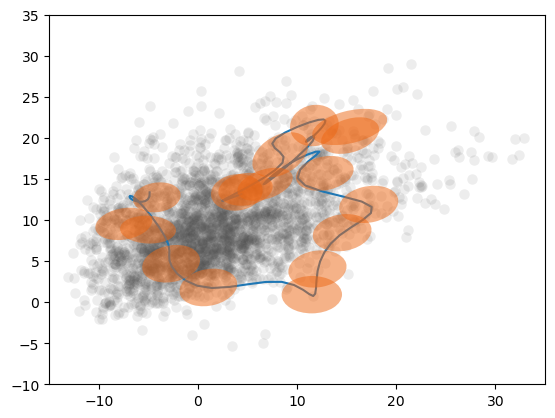

In [14]:
%matplotlib inline
from scipy.interpolate import BSpline, make_interp_spline
historical_observations, _ = br.obs_ds.get_history()
n_steps = 25

fig, ax = plt.subplots()
all_observations = br.obs_ds.a
idx = br.obs_ds.index
width1= idx
width2 = 4*idx
ax.plot(all_observations[idx-width1:idx+width2,0], all_observations[idx-width1:idx+width2,1], '.',color="#505050", ms=15, alpha=.1, mew=0)

points = np.array([historical_observations[-n_steps:,0], historical_observations[-n_steps:,1]]).T
t = np.linspace(0,1,n_steps)

b = make_interp_spline(t,points)

points = b(np.linspace(0,1,100))
ax.plot(points[:,0],points[:,1])

ms = []
for i in range(n_steps):
    m = np.argmax(br.alpha_history[0][-1-i])
    ms.append(m)

for m in set(ms):    
    al.plotting_functions.add_2d_bubble(ax, br.bw.L[m], br.bw.mu[m], 3, alpha=.5)

ax.set_xlim([-15,35])
ax.set_ylim([-10,35])




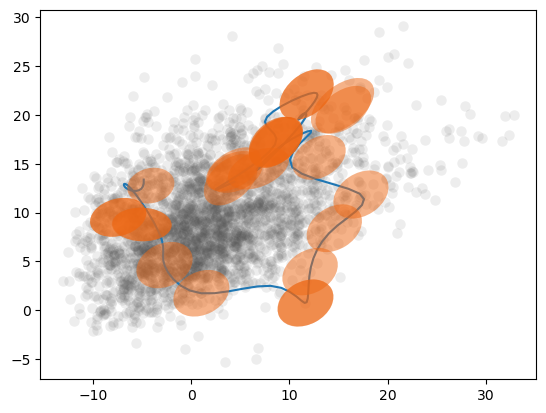

In [33]:
%matplotlib inline
from scipy.interpolate import BSpline, make_interp_spline
historical_observations, _ = br.obs_ds.get_history()
n_steps = 25

fig, ax = plt.subplots()
all_observations = br.obs_ds.a
idx = br.obs_ds.index
width1= idx
width2 = 4*idx
ax.plot(all_observations[idx-width1:idx+width2,0], all_observations[idx-width1:idx+width2,1], '.',color="#505050", ms=15, alpha=.1, mew=0)

points = np.array([historical_observations[-n_steps:,0], historical_observations[-n_steps:,1]]).T
t = np.linspace(0,1,n_steps)

b = make_interp_spline(t,points)

points = b(np.linspace(0,1,n_steps*5))
ax.plot(points[:,0],points[:,1])

for i in range(n_steps):
    m = np.argmax(br.alpha_history[0][-1-i])
    # todo: check that these indexes line up
    al.plotting_functions.add_2d_bubble(ax, br.L_history[-1-i][m], br.mu_history[-1-i][m], 3, alpha=.5)




In [12]:
import pickle
import glob

files = sorted(glob.glob(f"{al.CONFIG["output_path"]/"bubblewrap_runs"}/*.pickle"))
brs = []
for file in files[-8:]:
    with open(file, 'br') as fhan:
        brs.append(pickle.load(fhan))
br = brs[-6]

In [13]:

%matplotlib qt
import importlib
import copy
importlib.reload(al.plotting_functions)

br2 = copy.deepcopy(br)
br2.obs_ds.t = np.arange(br.obs_ds.t.size) * 0.05 +  br.obs_ds.t[0]
br = br2
al.plotting_functions.compare_metrics([br], offset=1, red_lines=[pre_jpca_t[n//3-1] ,])

/home/jgould/Documents/AdaptiveLatents/adaptive_latents/plotting_functions.py:493: UserWarning: check these timepoints actually line up, I'm just clipping here
  warnings.warn("check these timepoints actually line up, I'm just clipping here")


In [10]:
def get_polar_path(points):
    angles = []
    lengths = []
    for i in range(1,points.shape[0]-1):
        # here we define unit vectors paralell to the i and (i+1)th line segments in `points`
        current_segment = points[i] - points[i-1]
        next_segment = points[i+1] - points[i]
        lengths.append(np.linalg.norm(next_segment))
        current_segment /= np.linalg.norm(current_segment)
        next_segment /= np.linalg.norm(next_segment)
        
        # calculate the angle using arccos
        angle_magnitude = np.arccos(current_segment @ next_segment)
        angle_sign = -np.sign(np.linalg.det(np.column_stack([current_segment, next_segment])))
        angle_by_cos = angle_magnitude * angle_sign
        
        # calculate the angle using atan2
        orth_to_current_segment = np.array([[0,-1],[1,0]]) @ current_segment
        angle_by_atan2 = np.arctan2(next_segment @ orth_to_current_segment, next_segment @ current_segment)
        
        # check that both methods give the correct answer
        if not np.isclose(-angle_by_cos, angle_by_atan2):
            print(f"{-angle_by_cos} {angle_by_atan2}")
        
        
        angles.append(angle_by_cos)
    return angles, lengths
def make_angle_plot(ax, angles, lengths, bins=16, density=True):
    bins = np.linspace(-np.pi, np.pi, num=bins+1)
    
    # Bin data and record counts
    n, bins = np.histogram(angles, weights=lengths, bins=bins)
    widths = np.diff(bins)
    
    if density:
        # Area to assign each bin
        area = n / len(angles)
        # Calculate corresponding bin radius
        radius = (area/np.pi) ** .5
    # Otherwise plot frequency proportional to radius
    else:
        radius = n
    
    # Plot data on ax
    patches = ax.bar(bins[:-1], radius, zorder=1, align='edge', width=widths,
                     edgecolor='C0', fill=False, linewidth=1)
    
    # Set the direction of the zero angle
    ax.set_theta_offset(np.pi/2)
    
    # Remove ylabels for area plots (they are mostly obstructive)
    if density:
        ax.set_yticks([])

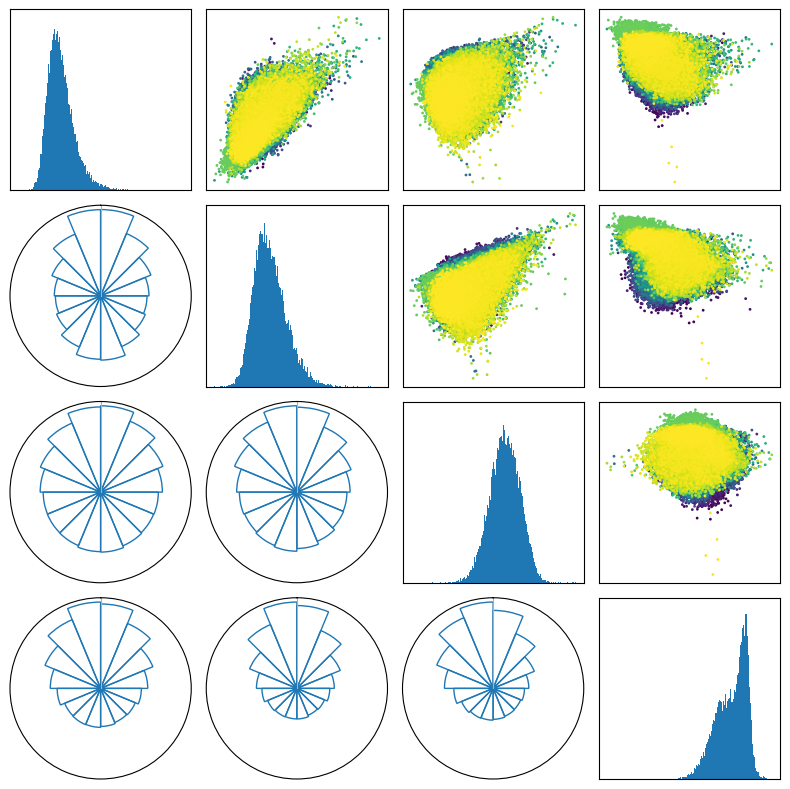

In [11]:
def inspect_high_d(A, fig=None, axs=None):
    k = A.shape[1]
    if fig is None or axs is None:
        fig, axs = plt.subplots(nrows=k, ncols=k, figsize=(8,8), tight_layout=True)
    
    for i in range(k):
        for j in range(k):
            if i < j:
                axs[i,j].scatter(A[:,i], A[:,j], c=t, s=1)
                axs[i,j].set_xticks([])
                axs[i,j].set_yticks([])
            elif i == j:
                axs[i,j].hist(A[:,i], bins=A.shape[0]//100)
                axs[i,i].set_xticks([])
                axs[i,i].set_yticks([])
            else:
                axs[i,j].remove()
                axs[i,j] = fig.add_subplot(k, k, (i*k +j)+1, projection='polar')
                angles, lengths = get_polar_path(A[:,[i,j]])
                make_angle_plot(axs[i,j], angles, lengths)
                
                axs[i,j].set_yticks([])
                axs[i,j].set_xticks([0])
                axs[i,j].set_xticklabels([""])
inspect_high_d(A)

### Some sort of continuity measure?

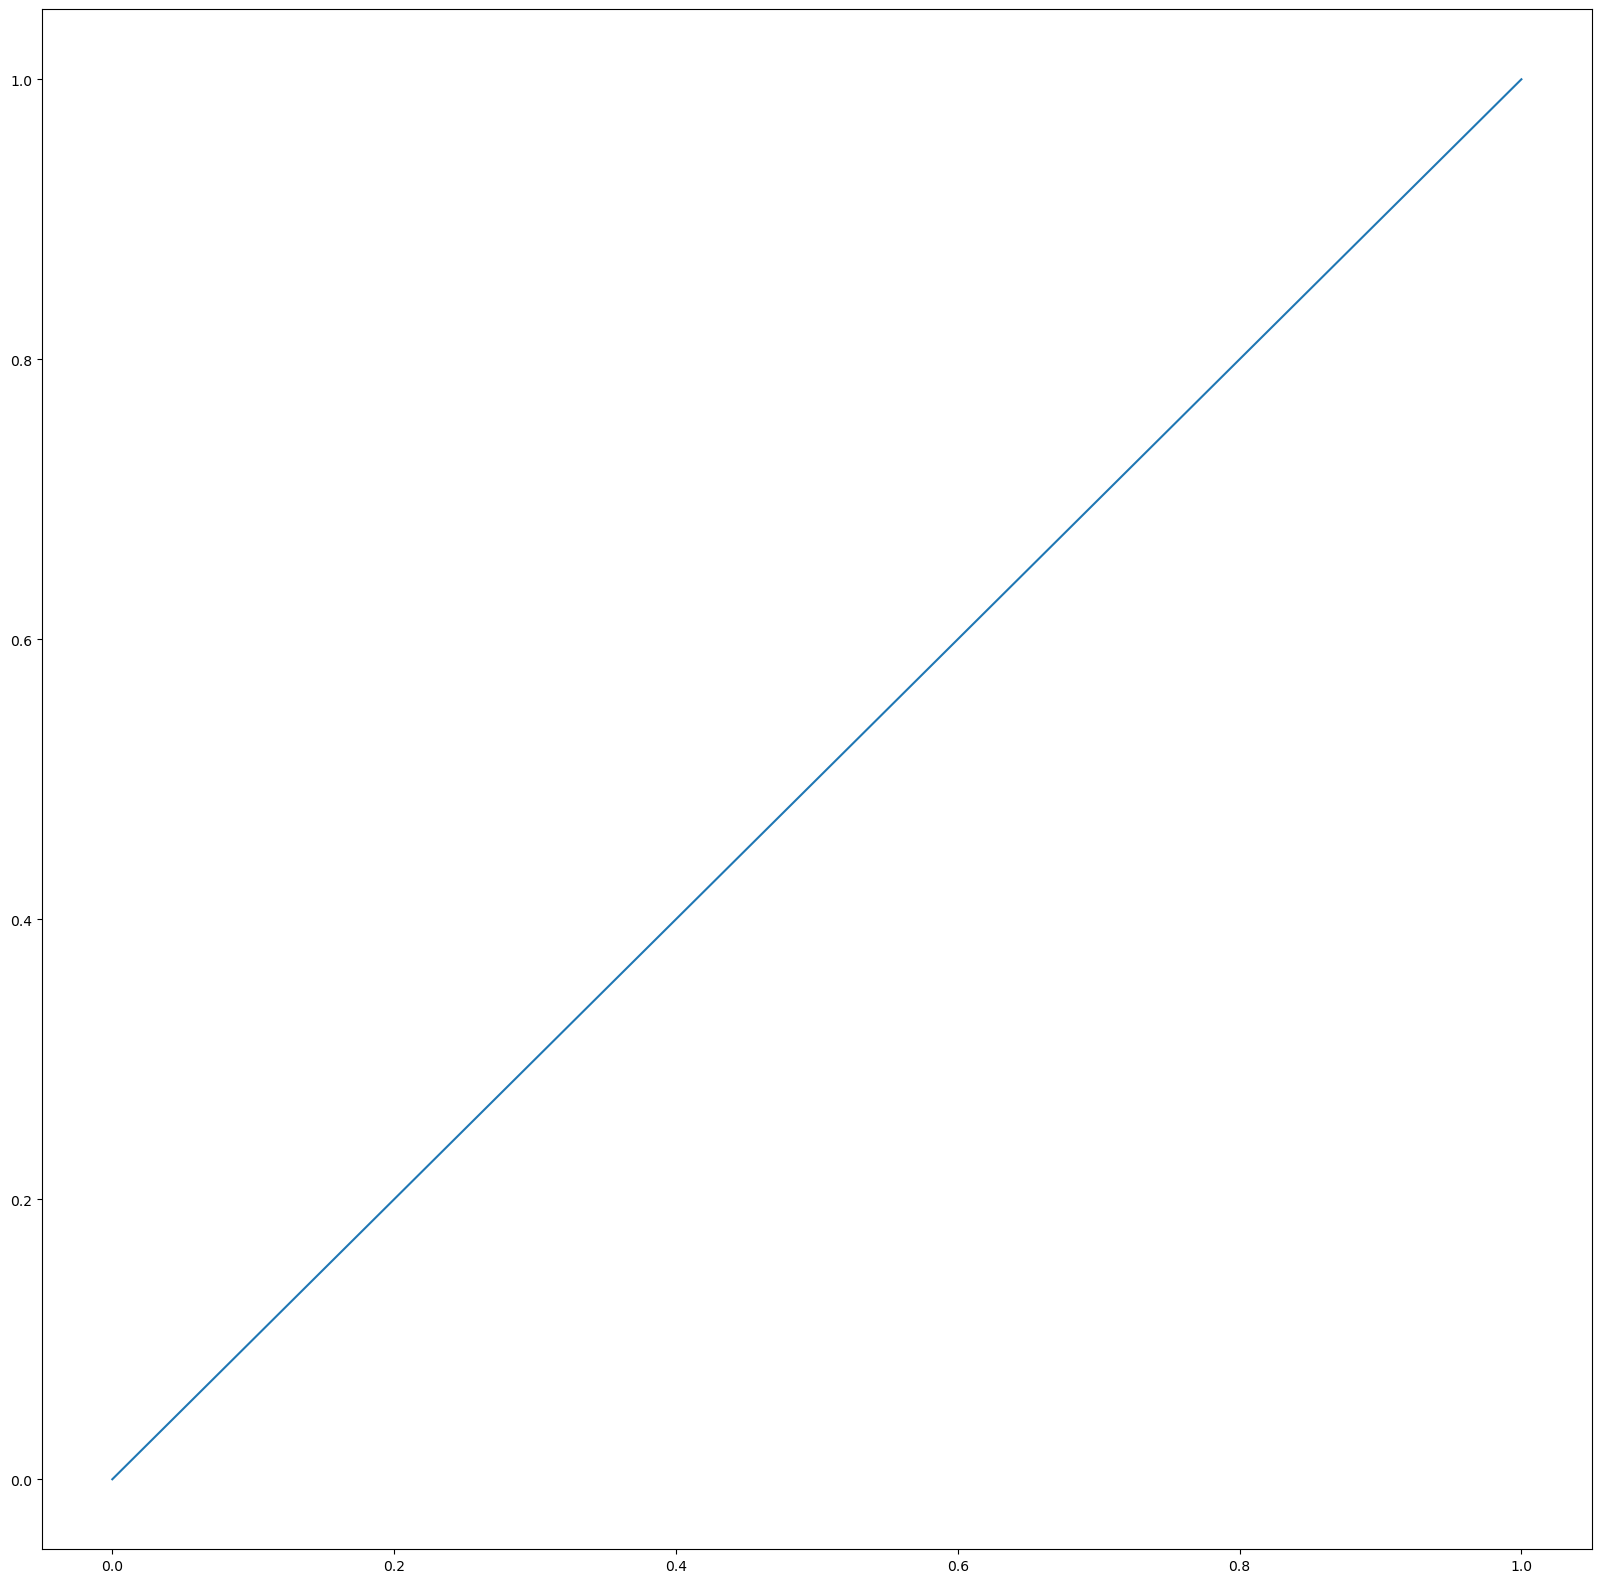

In [9]:
def test_making_powerpoints():
    from pathlib import Path
    import io
    from pptx import Presentation
    from pptx.util import Inches, Pt
    import matplotlib.pyplot as plt
    
    layouts_to_indexes = {
        "title":0,
        "blank":6,
    }
    
    prs = Presentation()
    slide = prs.slides.add_slide(prs.slide_layouts[layouts_to_indexes["blank"]])
    
    In = Inches(1)
    left = top = width = height = Inches(0)
    txBox = slide.shapes.add_textbox(0, 0, 3*In, 2*In)
    tf = txBox.text_frame
    
    tf.text = "This is text inside a textbox"
    
    tf.paragraphs[0].font.size = Pt(10)

    fig, ax = plt.subplots(figsize=(20,20))
    ax.plot(range(2), range(2))
    
    buf = io.BytesIO()
    fig.savefig(buf, format='png', dpi=200)
    buf.seek(0)
    slide.shapes.add_picture(buf, 1*In, 1*In, 2*In)
    
    prs.save(Path("/home/jgould/Dropbox (University of Michigan)/bwruns") / "testy.pptx")
test_making_powerpoints()